In [ ]:
import numpy as np  
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

 

In [3]:
import kagglehub

path = kagglehub.dataset_download("nirmalsankalana/rice-leaf-disease-image")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/rice-leaf-disease-image


In [10]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import random

2025-06-01 01:24:07.544328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748741047.785952      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748741047.851676      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
def load_and_resize_image(file_path, target_shape=(128, 128)):
    image = cv2.imread(file_path)
    resized_image = cv2.resize(image, target_shape)
    return resized_image

In [6]:
def load_image_class_by_directory(image_dir):
    image_files = os.listdir(image_dir)
    images = []
    for file in image_files:
        if file.endswith('.jpg') or file.endswith('.JPG'):   
            image_path = os.path.join(image_dir, file)
            resized_image = load_and_resize_image(image_path)
            images.append(resized_image)

    print(f"Num of images: {len(images)}")        
    print(f"Single image shape before flattening: {images[0].shape}")
    return images

In [6]:
def display_images(images, num_images_to_display = 6):
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 5))
    for i in range(num_images_to_display):
        image = images[i].astype(np.uint8)
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))   
        axes[i].axis('off')
    plt.show()

In [8]:
load_Bacterialblight = load_image_class_by_directory('/kaggle/input/rice-leaf-disease-image/Bacterialblight')
load_Blast = load_image_class_by_directory('/kaggle/input/rice-leaf-disease-image/Blast')
load_Brownspot = load_image_class_by_directory('/kaggle/input/rice-leaf-disease-image/Brownspot')
load_Tungro = load_image_class_by_directory('/kaggle/input/rice-leaf-disease-image/Tungro')

Num of images: 1584
Single image shape before flattening: (128, 128, 3)
Num of images: 1440
Single image shape before flattening: (128, 128, 3)
Num of images: 1600
Single image shape before flattening: (128, 128, 3)
Num of images: 1308
Single image shape before flattening: (128, 128, 3)


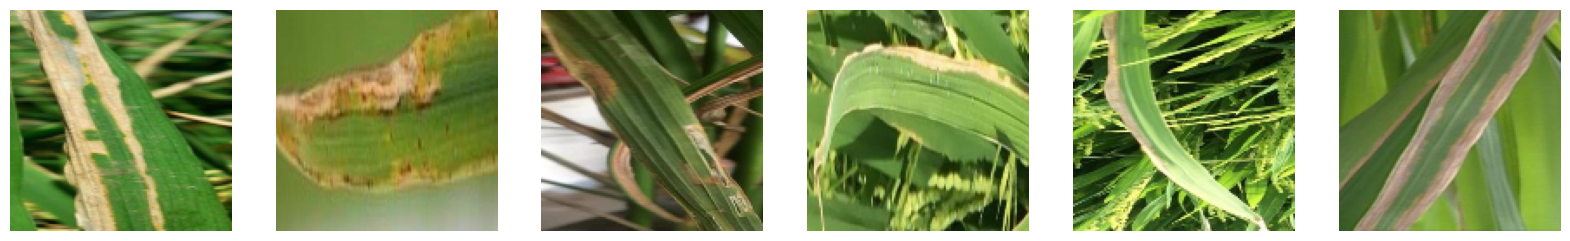

In [9]:
display_images(load_Bacterialblight)

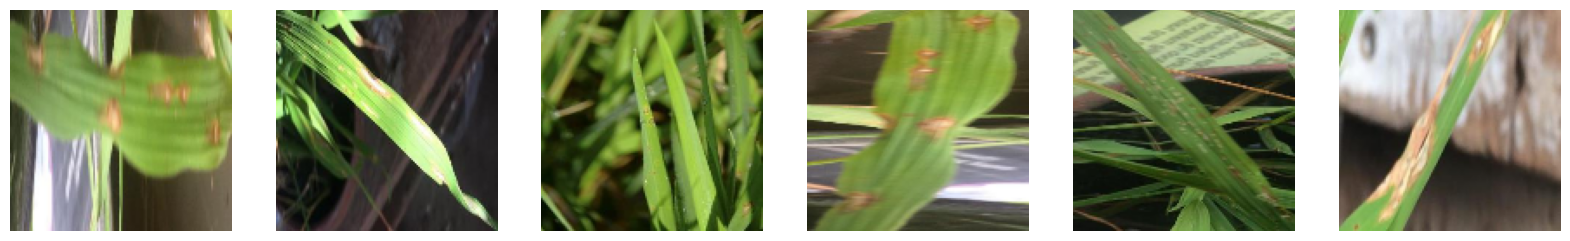

In [10]:
display_images(load_Blast)

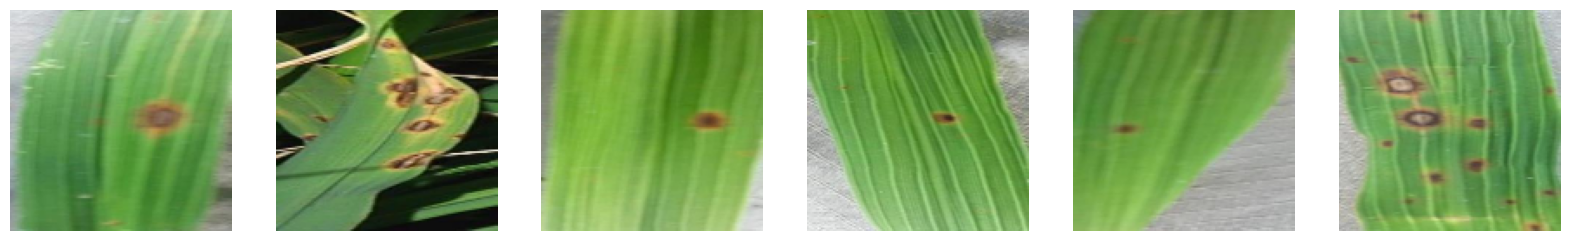

In [11]:
display_images(load_Brownspot)

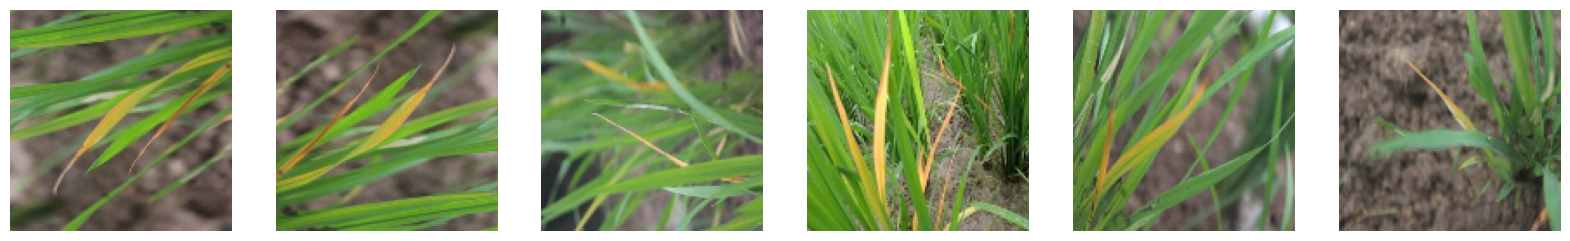

In [12]:
display_images(load_Tungro)

In [7]:
import os
import shutil
import random
from pathlib import Path

def split_dataset(input_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    random.seed(seed)
    class_names = os.listdir(input_dir)

    for class_name in class_names:
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        random.shuffle(images)

        total = len(images)
        train_end = int(train_ratio * total)
        val_end = train_end + int(val_ratio * total)

        splits = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for split, split_images in splits.items():
            split_class_dir = Path(output_dir) / split / class_name
            split_class_dir.mkdir(parents=True, exist_ok=True)
            for img in split_images:
                src = os.path.join(class_path, img)
                dst = os.path.join(split_class_dir, img)
                shutil.copy(src, dst)

# Ví dụ dùng:
split_dataset(
    input_dir='/kaggle/input/rice-leaf-disease-image',      # thư mục chứa 4 class
    output_dir='/kaggle/working/data_split',  # nơi lưu train/test/val
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15
)


In [8]:
train_data = '/kaggle/working/data_split/train'
test_data = '/kaggle/working/data_split/test'
val_data = '/kaggle/working/data_split/val'

In [11]:
img_size = (128, 128)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_data,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data,
    image_size=img_size,
    batch_size=batch_size
)

Found 4150 files belonging to 4 classes.


I0000 00:00:1748741071.476912      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748741071.477665      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 889 files belonging to 4 classes.
Found 893 files belonging to 4 classes.


In [12]:
pip install livelossplot

Note: you may need to restart the kernel to use updated packages.


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.utils import to_categorical
from livelossplot import PlotLossesKeras

In [18]:
model = models.Sequential() 

model.add(Input(shape=(128,128,3)))

model.add(Conv2D(128, (3, 3), activation="relu"))


model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation="relu"))          

model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(256, activation="relu"))

model.add(Dropout(0.5))

model.add(Dense(4, activation="softmax"))

opt = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 63, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │      14,745,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,824,260 (56.55 MB)

 Trainable params: 14,824,260 (56.55 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [28]:
epochs = 100
batch_size = 64


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)

Epoch 1/50


I0000 00:00:1748741502.065043     124 service.cc:148] XLA service 0x7f7b0800f210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748741502.067644     124 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748741502.067666     124 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748741502.484890     124 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/130 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.3223 - loss: 715.1207

I0000 00:00:1748741508.716168     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.2784 - loss: 123.0853 - val_accuracy: 0.2666 - val_loss: 1.3859
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.2619 - loss: 1.3792 - val_accuracy: 0.2666 - val_loss: 1.3858
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.2952 - loss: 1.3769 - val_accuracy: 0.2666 - val_loss: 1.3871
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.2876 - loss: 1.3657 - val_accuracy: 0.2666 - val_loss: 1.3848
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.2678 - loss: 1.3783 - val_accuracy: 0.2666 - val_loss: 1.3827
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.2659 - loss: 1.3697 - val_accuracy: 0.2655 - val_loss: 1.3831
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.2809 - loss: 1.3527 - val_accuracy: 0.2767 - val_loss: 1.3830
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.2944 - loss: 1.3617 - val_accuracy: 0.

In [29]:
loss, acc = model.evaluate(test_ds)
print(f'Test Accuracy: {acc:.4f}')


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9030 - loss: 0.3866
Test Accuracy: 0.9037
